<a href="https://colab.research.google.com/github/Vanderval31bs/transfer-learning-dio/blob/main/transfer_learning_dio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will try to use transfer learning to identify if a given image is a cat or a dog. The used model is VGG16 with the weights from imagenet.

First, lets do some basic imports


In [1]:
%matplotlib inline

import os
import zipfile

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Now we will donwload the data to a .zip file and unzip it.


In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2023-12-04 22:14:58--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.221.246.9, 2600:1407:3c00:158e::317f, 2600:1407:3c00:158c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.221.246.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  64.6MB/s    in 12s     

2023-12-04 22:15:11 (63.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



We have two categories for our data, Cat and Dog. The downloaded data is divided by category in the paths described below:


In [3]:
root = '/tmp/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print(categories)

['/tmp/PetImages/Dog', '/tmp/PetImages/Cat']


Lets define a helper function,  which will be used later.


In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Lets see how many images we have in each folder.


In [5]:
print(len(os.listdir('/tmp/PetImages/Dog/')))
print(len(os.listdir('/tmp/PetImages/Cat')))

12501
12501


The files Dog/11702.jpg and Cat/666.jpg are corrupted, so we may just remove them. (I discovered this when i was trying to upload them and an error was raised).


In [6]:

corrupted_dog = "/tmp/PetImages/Dog/11702.jpg"
corrupted_cat = "/tmp/PetImages/Cat/666.jpg"
if (os.path.isfile(corrupted_dog)):
  os.remove(corrupted_dog)
if (os.path.isfile(corrupted_cat)):
  os.remove(corrupted_cat)

Now i do something a little bit strange: a remove a lot of the images from the folders. The reason this is being done is that the colab does not have sufficient RAM to work with all the data.

Maybe i could have deleted the data in a random way instead of deleting just the first 11500, but for the purpose of this notebook i think it is fine.

Also, we could have kept the files in the folder and uploaded just some of them into the data variable.

In [7]:

for i in range(11500):
  for ext in ['.jpg','.png','.jpeg']:
    dog = "/tmp/PetImages/Dog/" + str(i + 301) + ext
    cat = "/tmp/PetImages/Cat/" + str(i + 1) + ext
    if (os.path.isfile(dog)):
      os.remove(dog)
    if (os.path.isfile(cat)):
      os.remove(cat)

Now we have a reduced number of images:


In [8]:
print(len(os.listdir('/tmp/PetImages/Dog/')))
print(len(os.listdir('/tmp/PetImages/Cat')))

1001
1001


So, lets upload the data in the folders to a data variable.

In [9]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Shuffle the data.

In [10]:
random.shuffle(data)

Lets divide the data into train, validation and test set.

In [11]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Now we separate the data from the labels

In [12]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

Now, we are doing some normalization of the image data (divide by 255) and convertin the label using to_categorial util from keras.

In [13]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


Seeing our data:


In [14]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


Look some images


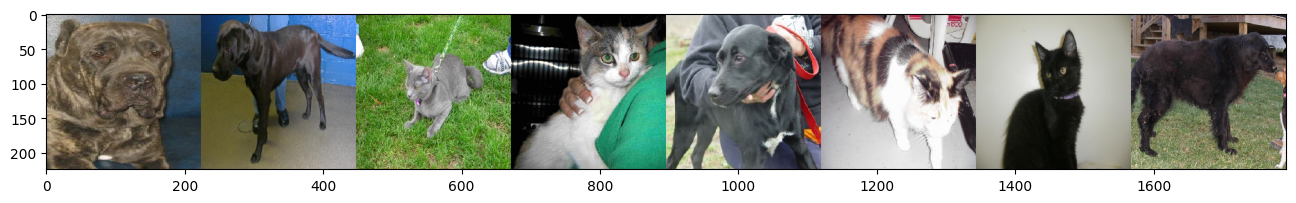

In [15]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Transfer learning


In [16]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Lets change the last layer of the neural network by a layer that outputs the classes of our problem (using softmax).

In [17]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We want to use the same weights that are previously trained by the model, except for the ones in the last layer:

In [18]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

See that we only have 8194 trainable params, because all the other ones were freezed. Lets now fit our model:

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=64,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
 6/22 [=======>......................] - ETA: 10:24 - loss: 0.8851 - accuracy: 0.5052

Let us see the loss and accuracy of  our model by epoch:

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Applying to our test set, we get the following loss and accuracy:

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)